Imports and utilities

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, confusion_matrix,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)

#Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

#For PCA visualization of clusters
from sklearn.decomposition import PCA

RANDOM_STATE = 42

#A small helper to make nice bar charts with labels on top
def plot_bar(values_dict, title, ylabel="Score"):
    names = list(values_dict.keys())
    scores = [values_dict[k] for k in names]
    plt.figure(figsize=(8,4))
    bars = plt.bar(names, scores)
    for b, s in zip(bars, scores):
        plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{s:.3f}",
                 ha='center', va='bottom', fontsize=9)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()


Load dataset and show basic information

In [ ]:
data_path = "/content/travel insurance.csv"
df = pd.read_csv(data_path)

print("Shape (rows, cols):", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
print("\nNull counts:\n", df.isna().sum())

#Peek first rows
df.head()

Shape (rows, cols): (63326, 11)

Columns:
 ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Gender', 'Age']

Dtypes:
 Agency                   object
Agency Type              object
Distribution Channel     object
Product Name             object
Claim                    object
Duration                  int64
Destination              object
Net Sales               float64
Commision (in value)    float64
Gender                   object
Age                       int64
dtype: object

Null counts:
 Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  45107
Age                         0
dtype: int64


,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


EDA: Class distribution (imbalance) and correlations

Class counts:
 Claim
No     62399
Yes      927
Name: count, dtype: int64


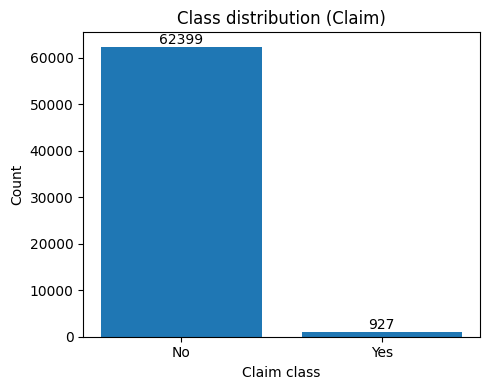

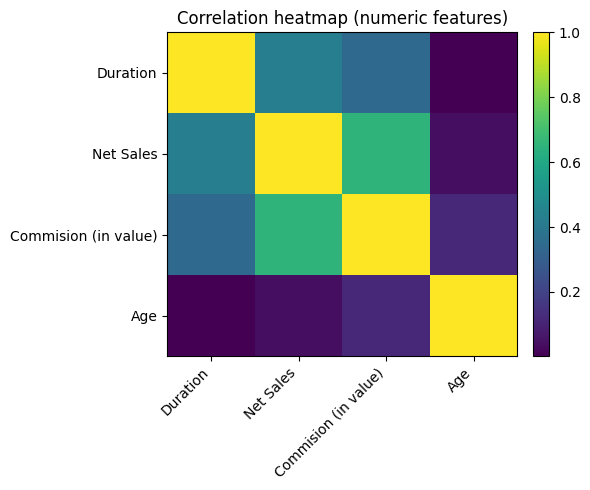

,Duration,Net Sales,Commision (in value),Age
Duration,1.000000,0.429235,0.344772,0.002468
Net Sales,0.429235,1.000000,0.651315,0.037756
Commision (in value),0.344772,0.651315,1.000000,0.118348
Age,0.002468,0.037756,0.118348,1.000000


In [ ]:
target = "Claim"

class_counts = df[target].value_counts().sort_index()
print("Class counts:\n", class_counts)

plt.figure(figsize=(5,4))
bars = plt.bar(class_counts.index.astype(str), class_counts.values)
for b, v in zip(bars, class_counts.values):
    plt.text(b.get_x()+b.get_width()/2, v, str(v), ha='center', va='bottom')
plt.title("Class distribution (Claim)")
plt.xlabel("Claim class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#Correlation heatmap for numeric features only (matplotlib)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr(numeric_only=True)

plt.figure(figsize=(6,5))
im = plt.imshow(corr, cmap='viridis', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()
plt.show()

corr

Preprocessing: impute, encode, and scale

In [ ]:
df["Claim"] = df["Claim"].astype(str).str.strip().str.lower().map({"yes": 1, "no": 0})

df = df.dropna(subset=["Claim"])

#Define target and features
y = df["Claim"].astype(int)
X = df.drop(columns=["Claim"])

categorical_cols = [
    "Agency", "Agency Type", "Distribution Channel",
    "Product Name", "Destination", "Gender"
]
numeric_cols = ["Duration", "Net Sales", "Commision (in value)", "Age"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

#Combine transformers
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",             #drop columns not listed
    sparse_threshold=0.3          #keep efficient sparse matrices if needed
)

#Try stratify first, fallback to normal split if error
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )
except ValueError:
    print("Stratified split failed (likely too few samples in one class). Using normal split.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42
    )

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Target distribution in train:\n", y_train.value_counts())
print("Target distribution in test:\n", y_test.value_counts())


Train shape: (44328, 10) Test shape: (18998, 10)
Target distribution in train:
 Claim
0    43679
1      649
Name: count, dtype: int64
Target distribution in test:
 Claim
0    18720
1      278
Name: count, dtype: int64


Train multiple supervised ML classifiers

In [ ]:
#Common pipelines
pipe_knn = Pipeline([
    ("prep", preprocess),
    ("clf", KNeighborsClassifier(n_neighbors=15))  #tune and try if sir ask
])

pipe_dt = Pipeline([
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(max_depth=12, random_state=RANDOM_STATE, class_weight="balanced"))
])

pipe_lr = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=200, n_jobs=None, class_weight="balanced"))
])

#For GaussianNB we need dense array
to_dense = FunctionTransformer(lambda x: x.toarray() if hasattr(x, "toarray") else x)
pipe_nb = Pipeline([
    ("prep", preprocess),
    ("to_dense", to_dense),
    ("clf", GaussianNB())
])

pipe_mlp = Pipeline([
    ("prep", preprocess),
    ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
                          activation="relu",
                          solver="adam",
                          max_iter=30,  #increase if we want higher accuracy (obviously costs time)
                          random_state=RANDOM_STATE))
])

models = {
    "KNN": pipe_knn,
    "DecisionTree": pipe_dt,
    "LogisticRegression": pipe_lr,
    "NaiveBayes": pipe_nb,
    "NeuralNet": pipe_mlp
}

#Train and evaluate
results = {}
probas = {}  #store predicted probabilities for ROC
y_preds = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_preds[name] = y_pred

    #Some models have predict_proba, some don't
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        probas[name] = y_prob
    else:
        #fallback: use decision_function if available, scaled to [0,1]
        if hasattr(model, "decision_function"):
            scores = model.decision_function(X_test)
            #Min-max scale to [0,1] for plotting ROC(rough)
            y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
            probas[name] = y_prob

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, probas[name]) if name in probas else np.nan

    results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "auc": auc
    }

pd.DataFrame(results).T.sort_values(by="accuracy", ascending=False)


Training KNN...

Training DecisionTree...

Training LogisticRegression...

Training NaiveBayes...

Training NeuralNet...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


,accuracy,precision,recall,auc
KNN,0.985367,0.000000,0.000000,0.698805
NeuralNet,0.984946,0.166667,0.007194,0.801404
DecisionTree,0.833193,0.052338,0.607914,0.756377
LogisticRegression,0.795926,0.051806,0.748201,0.825452
NaiveBayes,0.052111,0.014938,0.982014,0.514853


Confusion Matrices and ROC curves for comparison

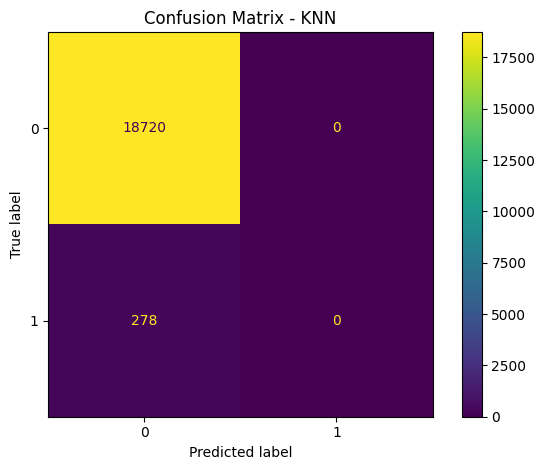

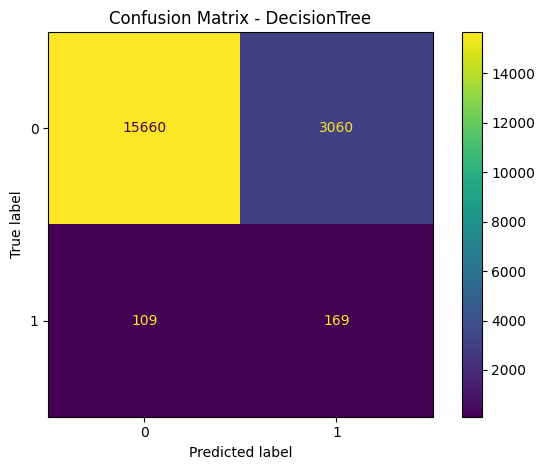

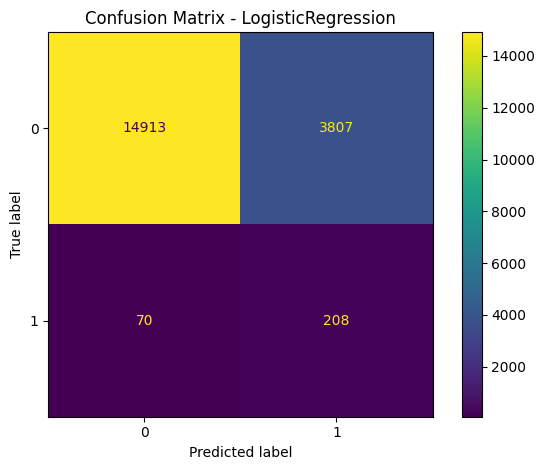

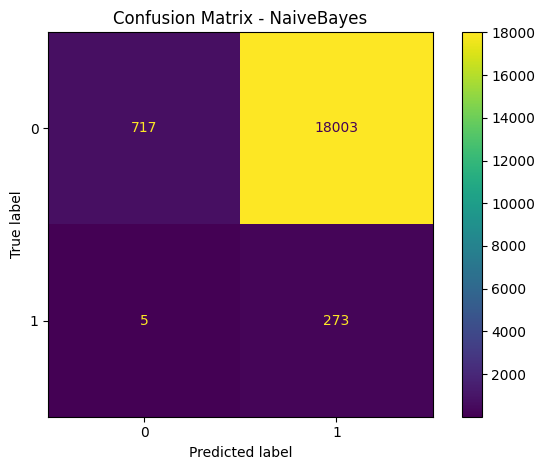

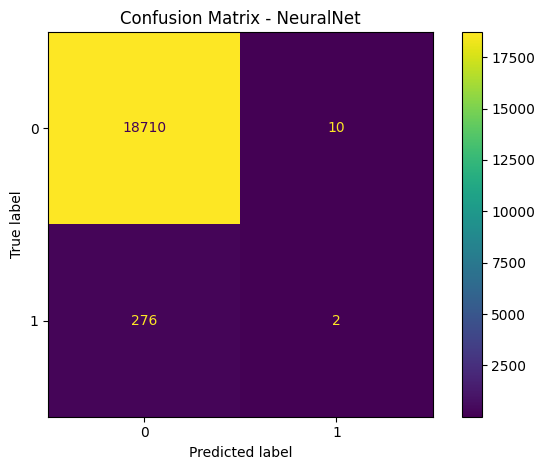

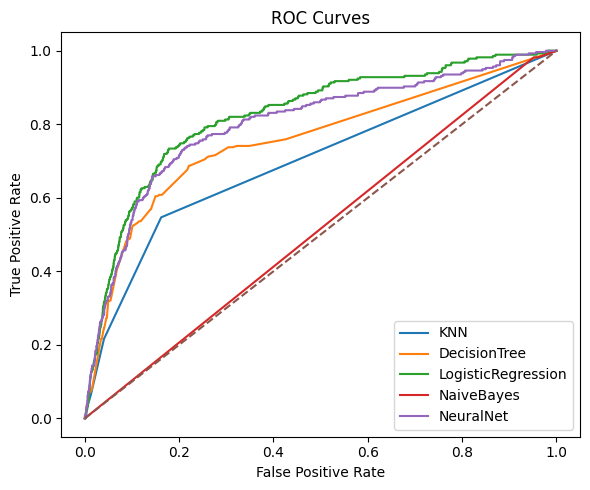

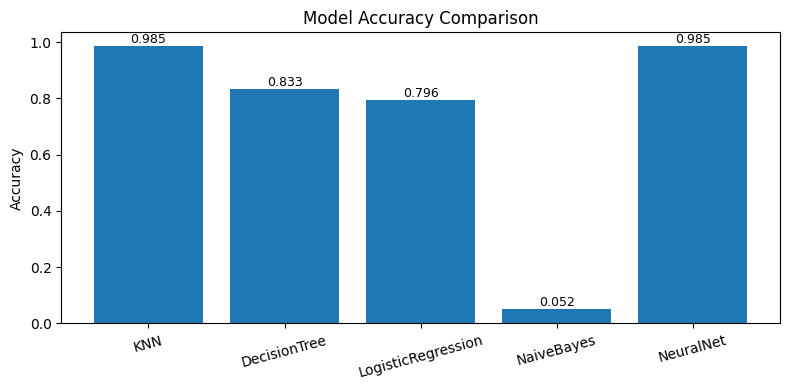

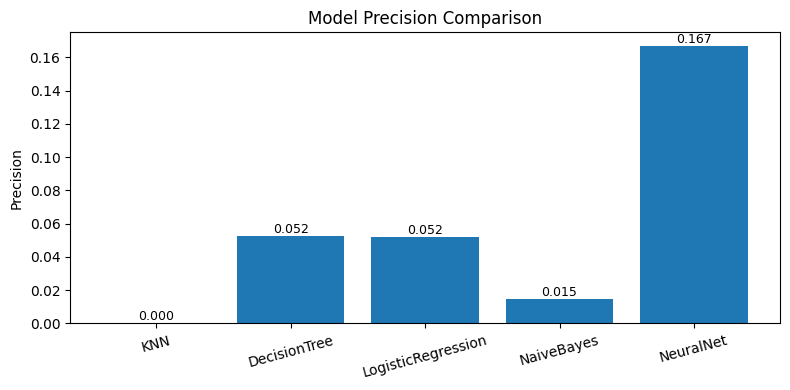

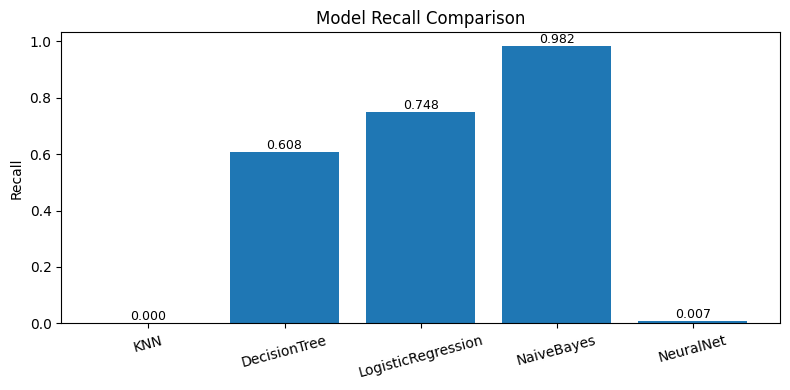

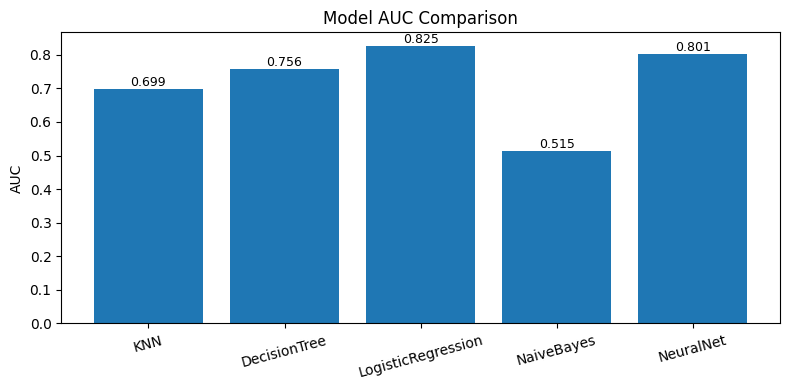

In [ ]:
# Confusion matrices
for name, y_pred in y_preds.items():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

#ROC curves (for models that have probabilities)
plt.figure(figsize=(6,5))
for name, y_prob in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()

#Bar chart comparisons
acc_dict = {k: v["accuracy"] for k, v in results.items()}
plot_bar(acc_dict, "Model Accuracy Comparison", ylabel="Accuracy")

prec_dict = {k: v["precision"] for k, v in results.items()}
plot_bar(prec_dict, "Model Precision Comparison", ylabel="Precision")

rec_dict = {k: v["recall"] for k, v in results.items()}
plot_bar(rec_dict, "Model Recall Comparison", ylabel="Recall")

auc_dict = {k: v["auc"] for k, v in results.items()}
plot_bar(auc_dict, "Model AUC Comparison", ylabel="AUC")

Unsupervised: KMeans (2 clusters) + PCA visualization

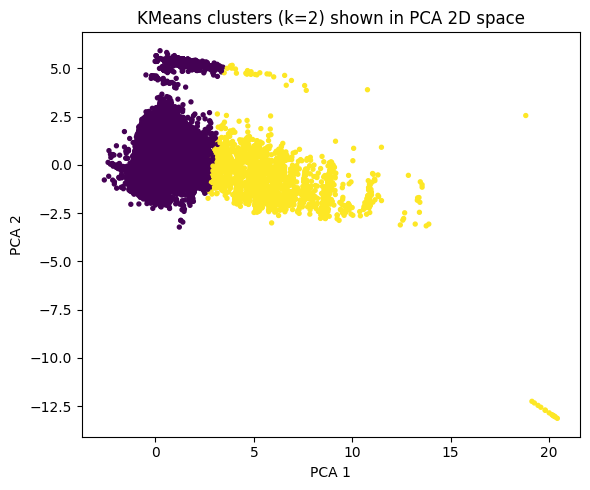

In [ ]:
#We fit KMeans on the TRAIN features only
kmeans_pipeline = Pipeline([
    ("prep", preprocess),
    ("kmeans", KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10))
])

kmeans_pipeline.fit(X_train)

#transform the full dataset for PCA visualization
prep_only = Pipeline([("prep", preprocess)])
X_all_prepped = prep_only.fit_transform(X)
if hasattr(X_all_prepped, "toarray"):
    X_all_dense = X_all_prepped.toarray()
else:
    X_all_dense = X_all_prepped

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_all_dense)

clusters_all = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10).fit_predict(X_all_dense)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_all, s=8)
plt.title("KMeans clusters (k=2) shown in PCA 2D space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

In [ ]:
#how clusters align with actual labels (not required for unsupervised, but insightful)
pd.crosstab(clusters_all, y, rownames=["Cluster"], colnames=["Claim"])


Claim,0,1
Cluster,,
0,60066,703
1,2333,224


Save Metrics Tables

In [ ]:
results_df = pd.DataFrame(results).T
results_df_path = "model_comparison_metrics.csv"
results_df.to_csv(results_df_path, index=True)
print("Saved:", os.path.abspath(results_df_path))

#Saving class distribution too
class_counts_df = class_counts.rename_axis("Claim").reset_index(name="Count")
class_counts_df_path = "class_distribution.csv"
class_counts_df.to_csv(class_counts_df_path, index=False)
print("Saved:", os.path.abspath(class_counts_df_path))

Saved: /content/model_comparison_metrics.csv
Saved: /content/class_distribution.csv


Handle Class Imbalance with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#Logistic Regression with SMOTE
smote = SMOTE(random_state=RANDOM_STATE)

pipe_lr_smote = ImbPipeline([
    ("prep", preprocess),
    ("smote", smote),
    ("clf", LogisticRegression(max_iter=200, class_weight=None))
])

pipe_lr_smote.fit(X_train, y_train)
y_pred_lr_smote = pipe_lr_smote.predict(X_test)

acc = accuracy_score(y_test, y_pred_lr_smote)
prec = precision_score(y_test, y_pred_lr_smote)
rec = recall_score(y_test, y_pred_lr_smote)
auc = roc_auc_score(y_test, pipe_lr_smote.predict_proba(X_test)[:,1])

print("Logistic Regression + SMOTE")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("AUC:", auc)

Logistic Regression + SMOTE
Accuracy: 0.7780819033582482
Precision: 0.048601558917927556
Recall: 0.762589928057554
AUC: 0.8238998224497325


Hyperparameter Tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

#Logistic Regression
param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "lbfgs"]
}
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr,
                       cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression params:", grid_lr.best_params_)
print("Best CV score:", grid_lr.best_score_)
y_pred_lr_best = grid_lr.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred_lr_best))


#Decision Tree
param_grid_dt = {
    "clf__max_depth": [5, 10, 15, 20, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__criterion": ["gini", "entropy"]
}
grid_dt = GridSearchCV(pipe_dt, param_grid=param_grid_dt,
                       cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
grid_dt.fit(X_train, y_train)

print("Best Decision Tree params:", grid_dt.best_params_)
print("Best CV score:", grid_dt.best_score_)
y_pred_dt_best = grid_dt.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred_dt_best))


#KNN
param_grid_knn = {
    "clf__n_neighbors": [3, 5, 10, 15, 25],
    "clf__weights": ["uniform", "distance"]
}
grid_knn = GridSearchCV(pipe_knn, param_grid=param_grid_knn,
                        cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
grid_knn.fit(X_train, y_train)

print("Best KNN params:", grid_knn.best_params_)
print("Best CV score:", grid_knn.best_score_)
y_pred_knn_best = grid_knn.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred_knn_best))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Logistic Regression params: {'clf__C': 0.01, 'clf__solver': 'liblinear'}
Best CV score: 0.8196399566865186
Test accuracy: 0.8149805242657122
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Decision Tree params: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_split': 2}
Best CV score: 0.9711243457859592
Test accuracy: 0.9706284872091799
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best KNN params: {'clf__n_neighbors': 10, 'clf__weights': 'uniform'}
Best CV score: 0.9853591409492871
Test accuracy: 0.9853668807242868


Collect Tuned Results

In [ ]:
tuned_results = {
    "LogReg_best": {
        "accuracy": accuracy_score(y_test, y_pred_lr_best),
        "precision": precision_score(y_test, y_pred_lr_best),
        "recall": recall_score(y_test, y_pred_lr_best),
        "auc": roc_auc_score(y_test, grid_lr.predict_proba(X_test)[:,1])
    },
    "DecisionTree_best": {
        "accuracy": accuracy_score(y_test, y_pred_dt_best),
        "precision": precision_score(y_test, y_pred_dt_best),
        "recall": recall_score(y_test, y_pred_dt_best),
        "auc": roc_auc_score(y_test, grid_dt.predict_proba(X_test)[:,1])
    },
    "KNN_best": {
        "accuracy": accuracy_score(y_test, y_pred_knn_best),
        "precision": precision_score(y_test, y_pred_knn_best),
        "recall": precision_score(y_test, y_pred_knn_best),
        "auc": roc_auc_score(y_test, grid_knn.predict_proba(X_test)[:,1])
    }
}

tuned_results_df = pd.DataFrame(tuned_results).T
tuned_results_df.to_csv("tuned_model_comparison.csv", index=True)
tuned_results_df

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,accuracy,precision,recall,auc
LogReg_best,0.814981,0.054990,0.719424,0.837845
DecisionTree_best,0.970628,0.048387,0.053957,0.519118
KNN_best,0.985367,0.000000,0.000000,0.661840
